<a href="https://colab.research.google.com/github/deshanchathusanka/machine-learning-algorithms/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

* Mount Google Drive 
* Create softlink to access files from Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstLabel_fine.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstLabel_coarse.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstImage.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnLabel_fine.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnLabel_coarse.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnImage.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/fine_labels.csv" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/coarse_labels.csv" "/content/"

!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/x_train.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/x_test.npy" "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/tstLabel_fine.npy': File exists
ln: failed to create symbolic link '/content/tstLabel_coarse.npy': File exists
ln: failed to create symbolic link '/content/tstImage.npy': File exists
ln: failed to create symbolic link '/content/trnLabel_fine.npy': File exists
ln: failed to create symbolic link '/content/trnLabel_coarse.npy': File exists
ln: failed to create symbolic link '/content/trnImage.npy': File exists
ln: failed to create symbolic link '/content/fine_labels.csv': File exists
ln: failed to create symbolic link '/content/coarse_labels.csv': File exists
ln: failed to create symbolic link '/content/x_train.npy': File exists
ln: failed to create symbolic link '/content/x_test.npy': File exists


**Package installation**

In [ ]:
!pip install keras-tuner -q

**Import Statements**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
from sklearn.preprocessing import StandardScaler

############### Dimensionality Reduction ################
from sklearn.decomposition import PCA
from bisect import bisect_left
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


############## Support Vector Machine ###################
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

############## Convolutional Neural Network #########################
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

############## Hyperparameter tuning ######################
from kerastuner.tuners import RandomSearch

############## Evaluation #################################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


**Review Dataset and Labels**

Number of Fine Labels(Class) : (100,)
Number of Coarse Labels(Super Class) : (20,)

Shape of Original Images : (32, 32, 3, 50000)
Shape of Fine Labels : (50000,)
Shape of Coarse Labels : (50000,)



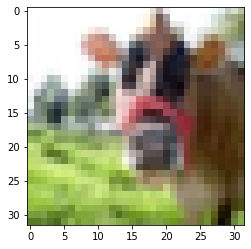

Fine Label : cattle
Coarse Label : large omnivores and herbivores


In [ ]:
images = np.load('./trnImage.npy')
images_test = np.load('./tstImage.npy')

label_fine = np.load('./trnLabel_fine.npy')
label_coarse = np.load('./trnLabel_coarse.npy')
label_fine_test = np.load('./tstLabel_fine.npy')
label_coarse_test = np.load('./tstLabel_coarse.npy')
label_fine_names = pd.read_csv("fine_labels.csv", header=None, delimiter=',').iloc[0]
label_coarse_names = pd.read_csv("coarse_labels.csv", header=None, delimiter=',').iloc[0]

############## shapes of dataset ###################
print(f'Number of Fine Labels(Class) : {label_fine_names.shape}')
print(f'Number of Coarse Labels(Super Class) : {label_coarse_names.shape}\n')
print(f'Shape of Original Images : {images.shape}') # (Height, Width, Channel, Samples)
print(f'Shape of Fine Labels : {label_fine.shape}')
print(f'Shape of Coarse Labels : {label_coarse.shape}\n')

############# understand dataset content ###############
img_index = 0
image = images[:,:,:,img_index]
plt.figure()
plt.imshow(image)
plt.show()
label_fine_name = label_fine_names[label_fine[img_index]]
label_course_name = label_coarse_names[label_coarse[img_index]]
print(f'Fine Label : {label_fine_name}')
print(f'Coarse Label : {label_course_name}')

**Manual Feature Extraction Using HOG (Histogram of Oriented Gradient)**

* Pixels per cell = (6, 6)
* Cells per block = (2, 2) 



* Pixels per image = (32, 32)
* Cells per image = (5, 5)



* Directions per cell = 9
* Directions per block = 9*4 = 36
* Number of strides = 4*4 = 16
* Number of total directions = 16*36 = 576

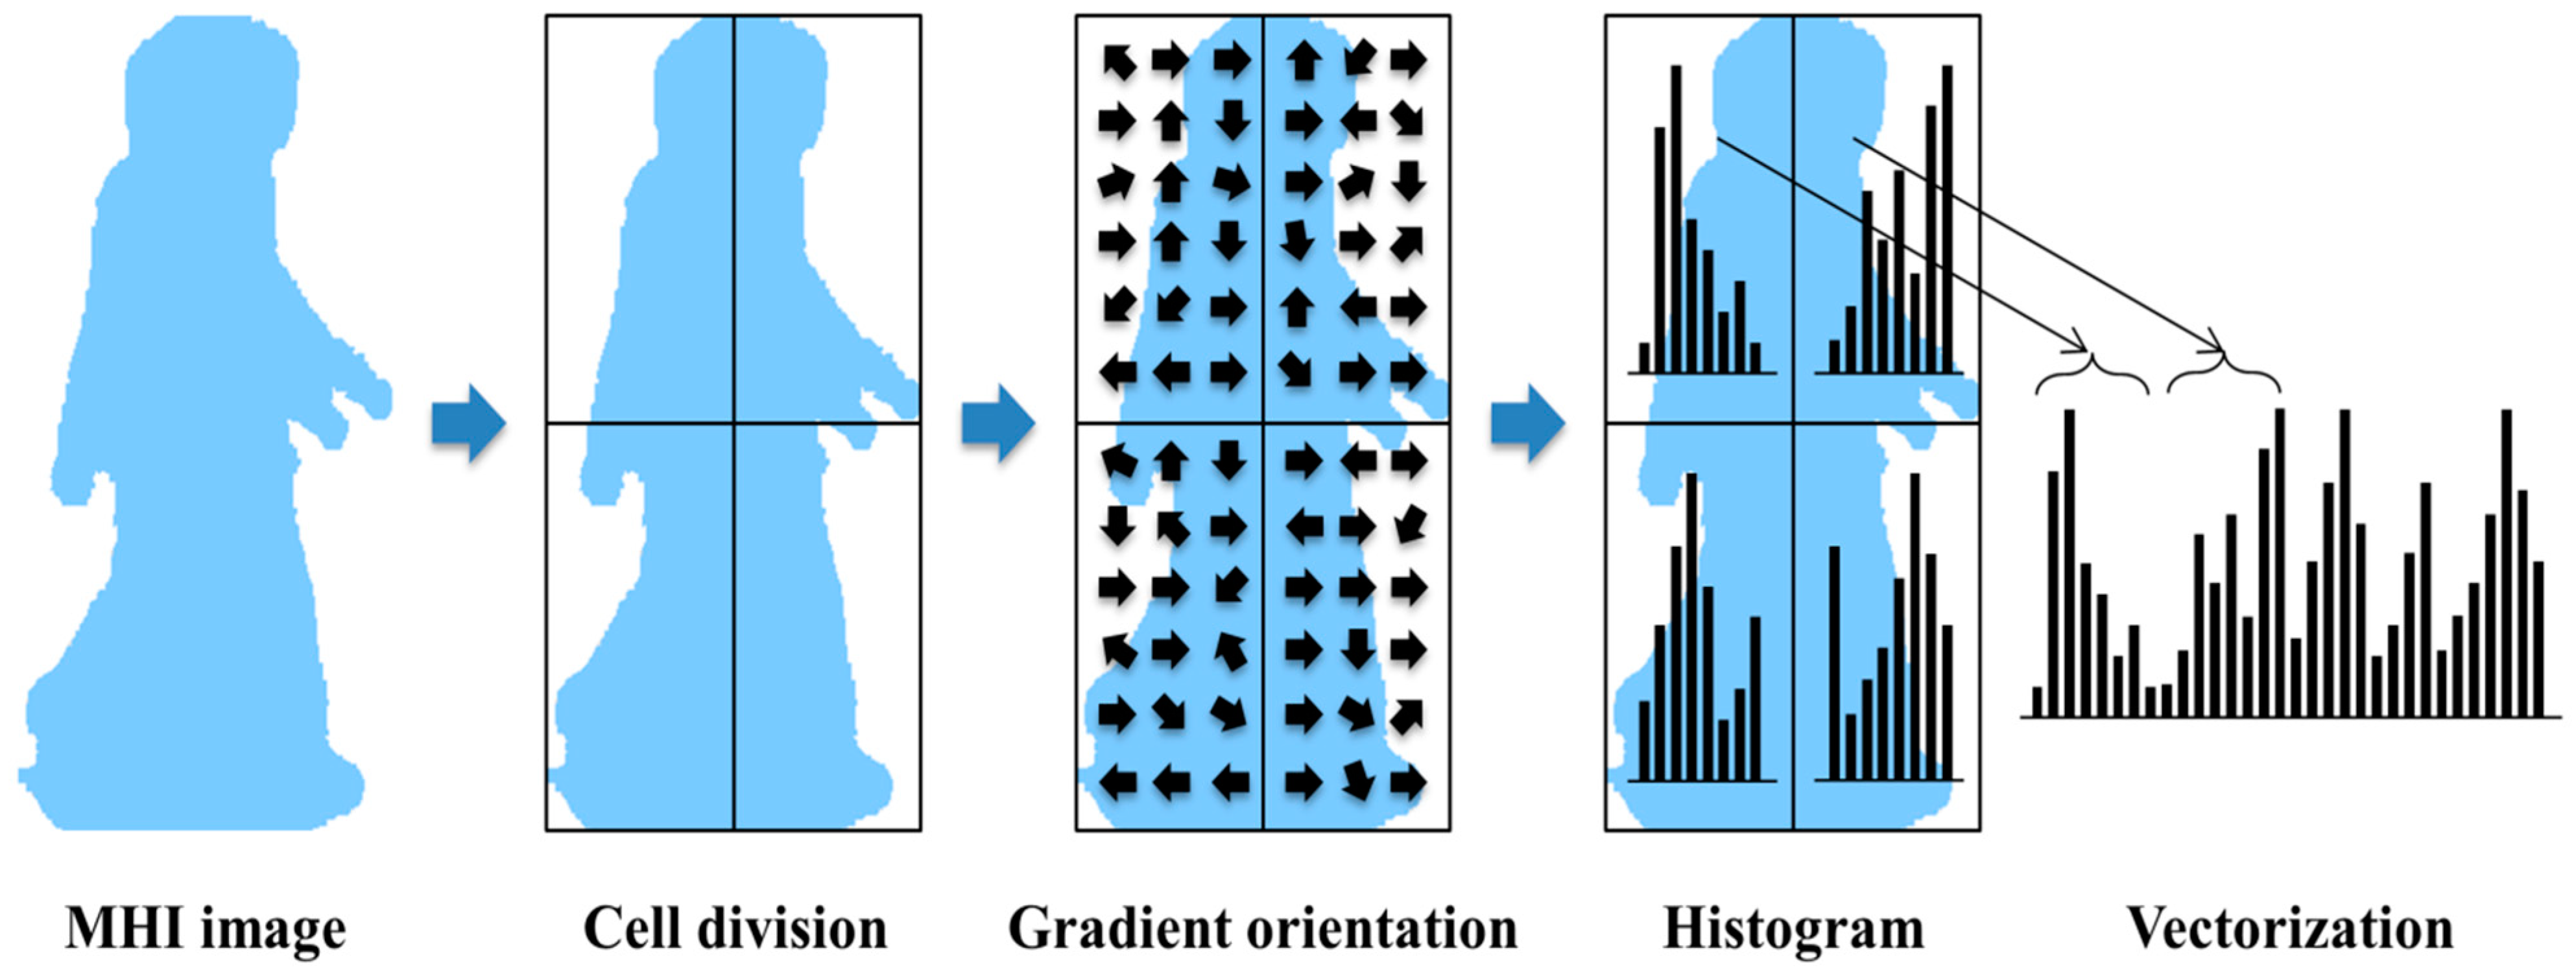

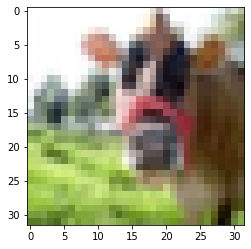

Number of Hog Feature : (576,)


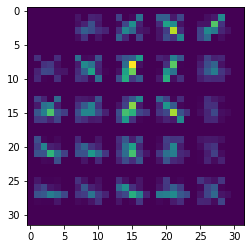

In [ ]:
NO_TRAIN_SAMPLE = 50000
NO_TEST_SAMPLE = 10000
NO_OF_FEATURE = 576
NO_OF_FINE_CATEGORIES = 100
NO_OF_COARSE_CATEGORIES = 100

########################### manually extract features of images and store in a file ###############################
image = images[:, :, :, 0]
plt.figure()
plt.imshow(image)
plt.show()
hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=True)
print(f'Number of Hog Feature : {hog_feature.shape}')
plt.figure()
plt.imshow(hog_image)
plt.show()

# x_train = np.empty(shape = (NO_TRAIN_SAMPLE, NO_OF_FEATURE))
# for index in range(0, NO_TRAIN_SAMPLE): # Training images
#   image = images[:, :, :, index]
#   hog_feature = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=False)
#   x_train[index] = hog_feature
# np.save(file = 'x_train.py', arr = x_train)

# x_test = np.empty(shape = (NO_TEST_SAMPLE, NO_OF_FEATURE))
# for index in range(0, NO_TEST_SAMPLE): # Testing images
#   image = images_test[:, :, :, index]
#   hog_feature = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=False)
#   x_test[index] = hog_feature
# np.save(file = 'x_test.py', arr = x_test)



In [ ]:
############### load feature extracted training and testing dataset ##############
x_train = np.load('./x_train.npy')
x_test = np.load('./x_test.npy')
y_train = label_fine
y_test = label_fine_test
y_train_coarse = label_coarse
y_test_coarse = label_coarse_test
print(f'Shape of X_Train : {x_train.shape}')
print(f'Shape of X_Test : {x_test.shape}')

############### Data standardization #################
scaler = StandardScaler()
# Calculate mean and variance of each feature for further pre-processing
scaler.fit(X = x_train) 
print(f'Shape of mean of dataset : {scaler.mean_.shape}') # (13,)
# Standardize data (Centering and Scaling)
x_train_standard = scaler.transform(X = x_train)
x_test_standard = scaler.transform(X = x_test)



Shape of X_Train : (50000, 576)
Shape of X_Test : (10000, 576)
Shape of mean of dataset : (576,)


**Dimensionality Reduction using Principle Component Analysis(PCA)**

 
 The main purpose of applying dimensionality reduction is to extract small number of new features(priciple components) that can explain more than 90% of total varience of original data.

Number of priciple components required to achieve 90% of total varience : 157


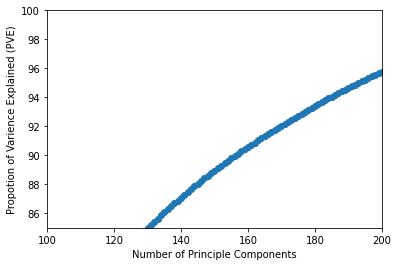

In [ ]:
pca = PCA().fit(X = x_train_standard, y = y_train)
singular_values = pca.explained_variance_
right_singular_vectors = pca.components_
singular_values_normalized = singular_values/sum(singular_values)

cum_sum_var = np.cumsum(singular_values_normalized)
num_components_90 = bisect_left(cum_sum_var, 0.9) + 1
print(f'Number of priciple components required to achieve 90% of total varience : {num_components_90}')

plt.figure()
plt.scatter(x = range(1, len(singular_values)+1), y = cum_sum_var*100)
plt.xlabel(xlabel = "Number of Principle Components")
plt.ylabel(ylabel = "Propotion of Varience Explained (PVE)")
plt.ylim([85,100])
plt.xlim([100,200])
plt.show()


In [ ]:
x_train_standard_reduced = pca.transform(X = x_train_standard)[:, 0: 157]
x_test_standard_reduced = pca.transform(X = x_test_standard)[:, 0: 157]

print(x_train_standard_reduced.shape)

(50000, 157)


**Dimensionality Reduction using Linear Descriminent Analysis(LDA)**

In [ ]:
################## extract LDA components ######################
"""
max(components) = min(features, classes-1)
"""
lda = LinearDiscriminantAnalysis(n_components = 99) 
lda.fit(X = x_train_standard, y = y_train)

#################### calculate LDA components ##################
x_train_standard_lda = lda.transform(X = x_train_standard)[:, 0: 99]
x_test_standard_lda = lda.transform(X = x_test_standard)[:, 0: 99]


**Support Vector Machine(SVM)**


* Features = HoG(Image) = 576

* Input = (50000, 576) = (Samples, Features)

* Output = (50000, 1)

In [ ]:
############################ Kernal selection : K-Fold cross validation ################################
def select_kernal(k, candidate_kernels, x_train, y_train, base_model) :

  model_fold_accuracy_map = []
  skf = StratifiedKFold(n_splits = k)
  for (train_index, val_index) in skf.split(X = x_train, y = y_train) :
    x_train_i, x_val_i = x_train[train_index], x_train[val_index]
    y_train_i, y_val_i = y_train[train_index], y_train[val_index]

    kernal_accuracy_i = []
    for kernel in candidate_kernels : 
      clf_param = dict(kernel = kernel)
      base_model.set_params(**clf_param)

      base_model.fit(X = x_train_i, y = y_train_i) 
      accuracy = base_model.score(X = x_val_i, y = y_val_i)
      kernal_accuracy_i.append(accuracy)
    model_fold_accuracy_map.append(kernal_accuracy_i)

  model_fold_accuracy_map = np.array(model_fold_accuracy_map)
  model_accuracy_list = np.sum(model_fold_accuracy_map, axis = 0)

  best_model_index = np.max(model_accuracy_list, axis = 0)
  best_kernel = candidate_kernels[best_model_index]

  return best_kernel

Accuracy(Coarse Label) : 39.58%

Confusion Matrix


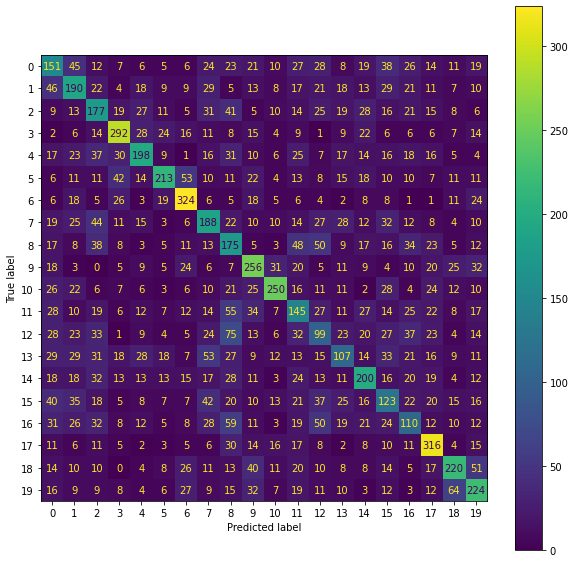

In [ ]:
################### Support Vector Machine Classifier ::: Coarse Labels #########################
svc = SVC(C = 1, kernel = 'rbf') 
svc.fit(X = x_train_standard, y = y_train_coarse) 

accuracy = svc.score(X = x_test_standard, y = y_test_coarse)
print(f'Accuracy(Coarse Label) : {accuracy*100}%')

print('\nConfusion Matrix')
predictions = svc.predict(x_test_standard)
cm = confusion_matrix(y_test_coarse, predictions, labels=svc.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)


Accuracy(Fine Label) : 28.299999999999997%


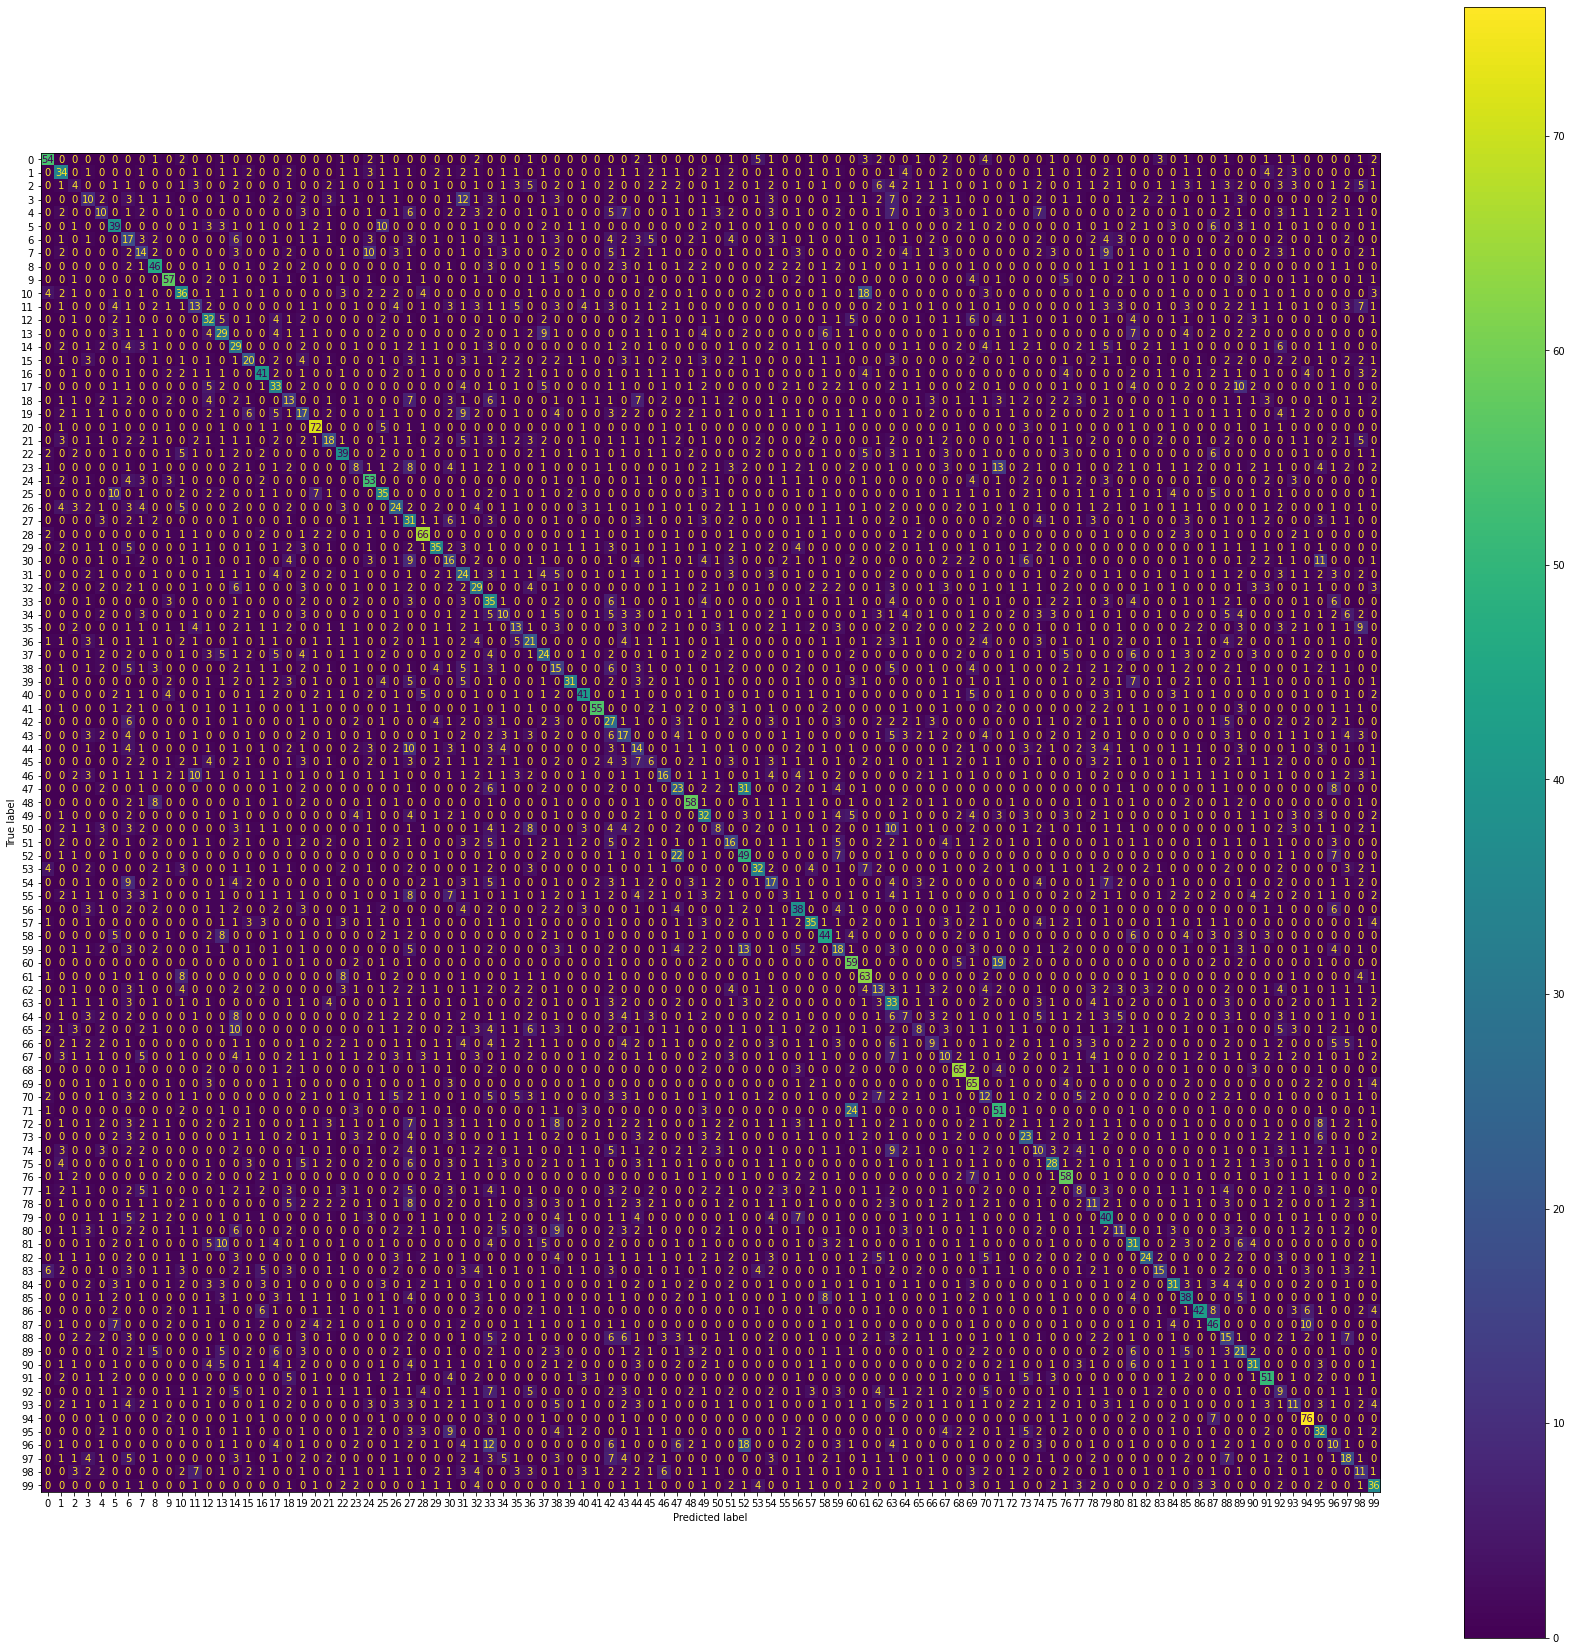

In [ ]:
###################  Support Vector Machine Classifier ::: Fine Labels #########################
svc = SVC(C = 1, kernel = 'rbf') 
svc.fit(X = x_train_standard, y = y_train) 

accuracy = svc.score(X = x_test_standard, y = y_test)
print(f'Accuracy(Fine Label) : {accuracy*100}%')

print('\nConfusion Matrix')
predictions = svc.predict(x_test_standard)
cm = confusion_matrix(y_test, predictions, labels=svc.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
fig, ax = plt.subplots(figsize=(30,30))
cmp.plot(ax=ax)

**Support Vector Machine + Dimensionality Reduction**

Accuracy(Coarse Label) : 39.269999999999996%

Confusion Matrix


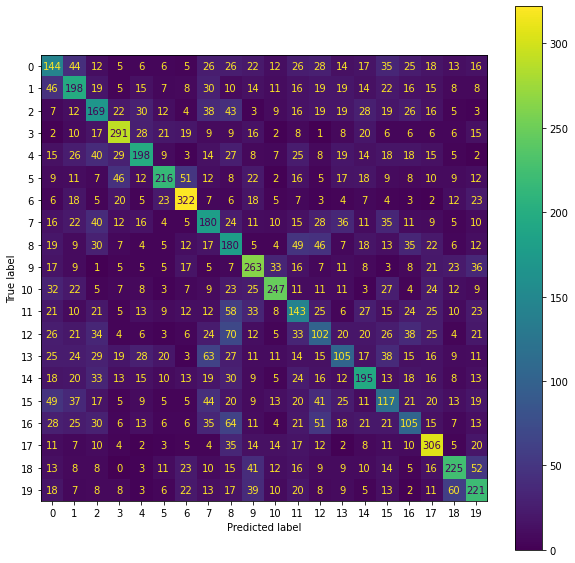

In [ ]:
################### Support Vector Machine Classifier ::: Coarse Labels #########################
svc = SVC(C = 1, kernel = 'rbf') 
svc.fit(X = x_train_standard_reduced, y = y_train_coarse) 

accuracy = svc.score(X = x_test_standard_reduced, y = y_test_coarse)
print(f'Accuracy(Coarse Label) : {accuracy*100}%')

print('\nConfusion Matrix')
predictions = svc.predict(x_test_standard_reduced)
cm = confusion_matrix(y_test_coarse, predictions, labels=svc.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)


Accuracy(Fine Label) : 28.46%

Confusion Matrix


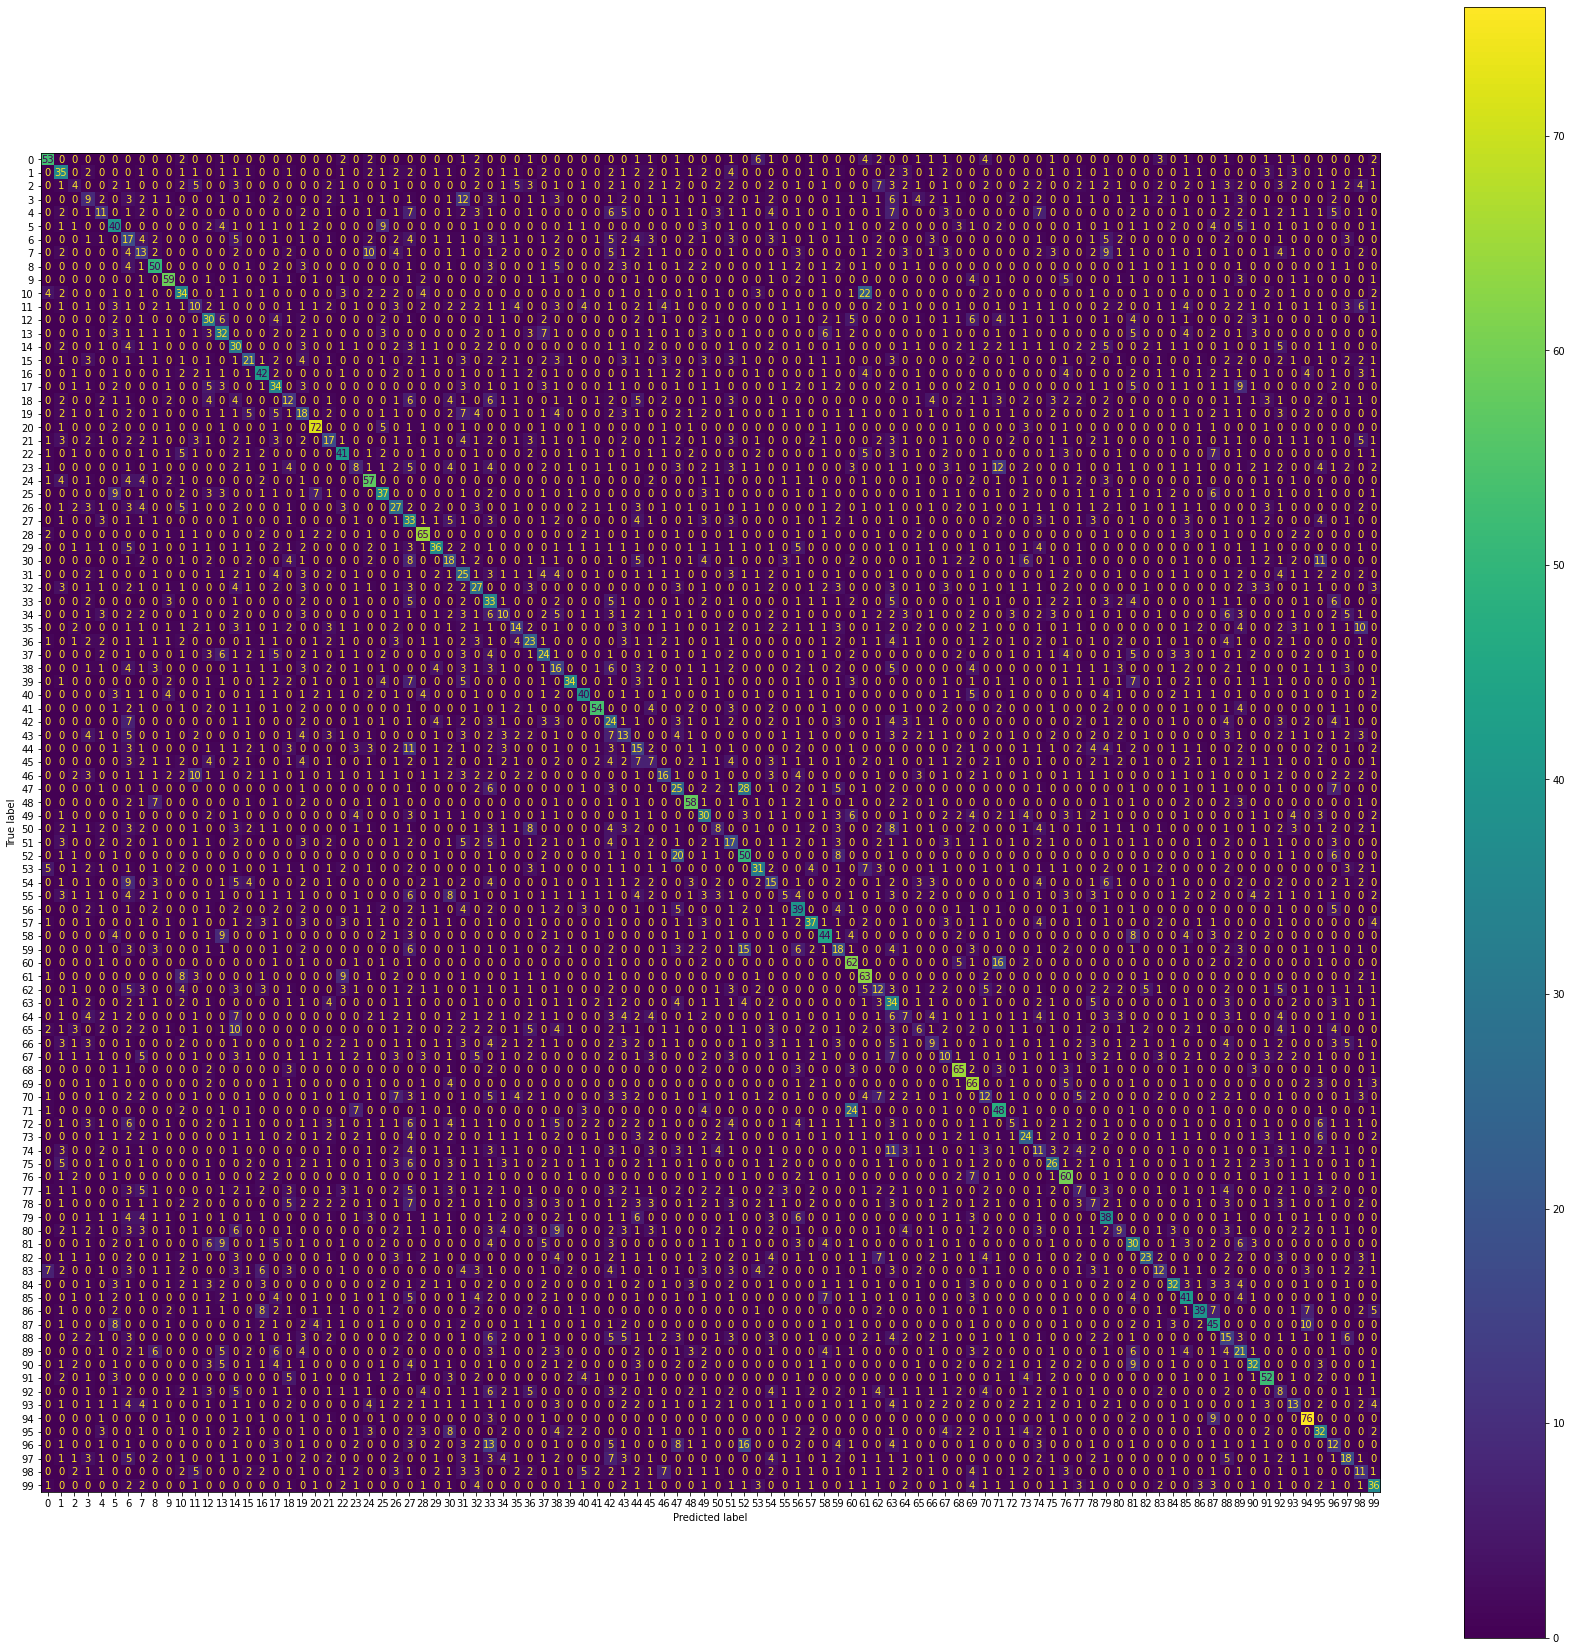

In [ ]:
###################  Support Vector Machine Classifier ::: Fine Labels #########################
svc = SVC(C = 1, kernel = 'rbf') 
svc.fit(X = x_train_standard_reduced, y = y_train) 

accuracy = svc.score(X = x_test_standard_reduced, y = y_test)
print(f'Accuracy(Fine Label) : {accuracy*100}%')

print('\nConfusion Matrix')
predictions = svc.predict(x_test_standard_reduced)
cm = confusion_matrix(y_test, predictions, labels=svc.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
fig, ax = plt.subplots(figsize=(30,30))
cmp.plot(ax=ax)

**Hyper-parameter tuning of Support Vector Machine**

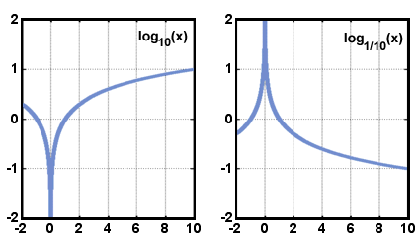

In [ ]:
################### Tune Support Vector Machine Classifier : Bayesian Optimization #########################
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

"""
Functionality of logspace
* Linearly distributed in log scale
* Default base >> 10
"""
param_space = {
    'C' : hp.choice('C', np.logspace(-1, 1, 3)), 
    'gamma' : hp.choice('gamma', ['scale','auto'] + np.logspace(-1, 1, 3).tolist()),
    'kernel' : hp.choice('kernel', ['rbf', 'poly'])
}

### define k-fold cross validation for each parameter set ###
"""
shuffle = True : Minimize the probability of extracting relationships between datapoints while training
"""
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

### define model and tune hyperparameters ###
def objective(params) :
  svc = SVC(**params)
  cross_validation_scores = cross_val_score(estimator = svc, X = x_train_standard, y = y_train_coarse, cv = kfold, scoring = 'accuracy')
  best_score = max(cross_validation_scores)
  loss = -best_model
  return {
      'loss' : loss, ## mandotory
      'params' : params,
      'status' : STATUS_OK ## mondotory
  }

bayes_trials = Trials() ## Inspect returning values during the experiment (Trace values)
best_model = fmin(fn = objective, space = param_space, algo = tpe.suggest, max_evals = 10, trials = bayes_trials) ## TPE(Tree Parzen Estimator) = Bayesian Optimizer


  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

**Artificial Neural Network**

Epoch 1/15
400/400 [==============================] - 87s 214ms/step - loss: 2.6783 - sparse_categorical_accuracy: 0.1840 - val_loss: 2.3856 - val_sparse_categorical_accuracy: 0.2818
Epoch 2/15
400/400 [==============================] - 82s 205ms/step - loss: 2.3908 - sparse_categorical_accuracy: 0.2629 - val_loss: 2.2559 - val_sparse_categorical_accuracy: 0.3154
Epoch 3/15
400/400 [==============================] - 85s 212ms/step - loss: 2.2758 - sparse_categorical_accuracy: 0.3011 - val_loss: 2.2048 - val_sparse_categorical_accuracy: 0.3274
Epoch 4/15
400/400 [==============================] - 82s 204ms/step - loss: 2.1937 - sparse_categorical_accuracy: 0.3232 - val_loss: 2.1591 - val_sparse_categorical_accuracy: 0.3468
Epoch 5/15
400/400 [==============================] - 81s 204ms/step - loss: 2.1328 - sparse_categorical_accuracy: 0.3415 - val_loss: 2.1415 - val_sparse_categorical_accuracy: 0.3535
Epoch 6/15
400/400 [==============================] - 81s 202ms/step - loss: 2.0816 -

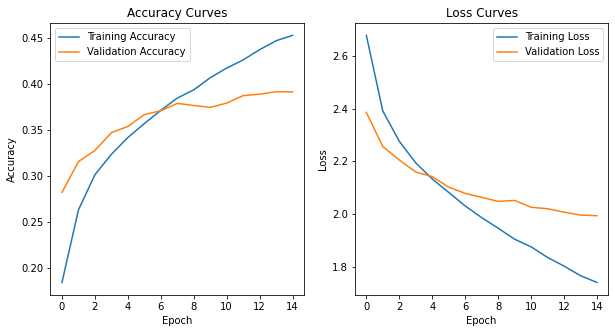

313/313 [==============================] - 7s 21ms/step - loss: 1.9830 - sparse_categorical_accuracy: 0.3876
Test set loss: 1.98, test set accuracy: 38.76%


In [ ]:
###################  Artificial Neural Network ::: Coarse Labels #########################
""" Define ANN Model """
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2048, activation=tf.nn.relu)) # 1st hidden layer : 784 neurons
model.add(Dropout(0.50))
model.add(tf.keras.layers.Dense(2048, activation=tf.nn.relu)) # 1st hidden layer : 784 neurons
model.add(Dropout(0.50))
model.add(tf.keras.layers.Dense(2048, activation=tf.nn.relu)) # 1st hidden layer : 784 neurons
model.add(Dropout(0.50))
model.add(tf.keras.layers.Dense(20, activation=tf.nn.softmax)) # output layer : 3 neurons

""" Compile Model """
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), # Strochastic Gradient Descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy

""" Train The Model """
# history = model.fit(x_train_standard, y_train_coarse, epochs=100, validation_split=0.2, verbose=1)
history = model.fit(x = x_train_standard,
                    y = y_train_coarse, 
                    batch_size = 100,
                    epochs=15, 
                    validation_split=0.2, 
                    verbose=1)

"""  Plot Accuracy And Loss Curves """
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

# # Predict labels from trained model
# y_hat = model.predict(x_test_mnist_normalized)

# """ Evaluate With Test Datatset """
#results = model.evaluate(x_test_standard, y_test_coarse)
results = model.evaluate(x_test_standard, y_test_coarse)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

# """ Analyse Training Cureves """
# print(y_test_mnist)
# print(np.argmax(y_hat, axis=1))

**Artificial Neural Network + Dimentionality Reduction**

Epoch 1/20
400/400 [==============================] - 86s 213ms/step - loss: 2.6768 - sparse_categorical_accuracy: 0.1851 - val_loss: 2.3773 - val_sparse_categorical_accuracy: 0.2802
Epoch 2/20
400/400 [==============================] - 81s 202ms/step - loss: 2.3967 - sparse_categorical_accuracy: 0.2627 - val_loss: 2.2707 - val_sparse_categorical_accuracy: 0.3105
Epoch 3/20
400/400 [==============================] - 82s 204ms/step - loss: 2.2849 - sparse_categorical_accuracy: 0.2992 - val_loss: 2.2041 - val_sparse_categorical_accuracy: 0.3313
Epoch 4/20
400/400 [==============================] - 84s 210ms/step - loss: 2.2157 - sparse_categorical_accuracy: 0.3152 - val_loss: 2.1768 - val_sparse_categorical_accuracy: 0.3495
Epoch 5/20
400/400 [==============================] - 82s 204ms/step - loss: 2.1585 - sparse_categorical_accuracy: 0.3347 - val_loss: 2.1287 - val_sparse_categorical_accuracy: 0.3564
Epoch 6/20
400/400 [==============================] - 81s 202ms/step - loss: 2.1162 -

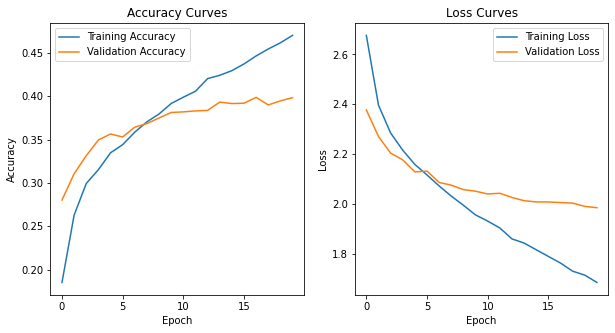

313/313 [==============================] - 7s 20ms/step - loss: 1.9762 - sparse_categorical_accuracy: 0.3951
Test set loss: 1.98, test set accuracy: 39.51%


In [ ]:
###################  Artificial Neural Network ::: Coarse Labels #########################
""" Define ANN Model """

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2048, activation=tf.nn.relu)) # 1st hidden layer : 784 neurons
model.add(Dropout(0.50))
model.add(tf.keras.layers.Dense(2048, activation=tf.nn.relu)) # 1st hidden layer : 784 neurons
model.add(Dropout(0.50))
model.add(tf.keras.layers.Dense(2048, activation=tf.nn.relu)) # 1st hidden layer : 784 neurons
model.add(Dropout(0.50))
model.add(tf.keras.layers.Dense(20, activation=tf.nn.softmax)) # output layer : 3 neurons

""" Compile Model """
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), # Strochastic Gradient Descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy

""" Train The Model """
# history = model.fit(x_train_standard, y_train_coarse, epochs=100, validation_split=0.2, verbose=1)
history = model.fit(x = x_train_standard_reduced,
                    y = y_train_coarse, 
                    batch_size = 100,
                    epochs=20, 
                    validation_split=0.2, 
                    verbose=1)

"""  Plot Accuracy And Loss Curves """
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

# # Predict labels from trained model
# y_hat = model.predict(x_test_mnist_normalized)

# """ Evaluate With Test Datatset """
#results = model.evaluate(x_test_standard, y_test_coarse)
results = model.evaluate(x_test_standard_reduced, y_test_coarse)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

# """ Analyse Training Cureves """
# print(y_test_mnist)
# print(np.argmax(y_hat, axis=1))

In [ ]:
###################  Tune Artificial Neural Network ::: Bayesian Optimisation ::: Coarse Labels #########################
from kerastuner.tuners import BayesianOptimization

def build_model(hp):
  model = keras.Sequential()

  ### Define hyper parameters ###
  layers_hp = hp.Int('num_layers', min_value = 2, max_value = 10, step =1 ) ## define number of hiden layers
  learning_rate_hp = hp.Choice('learning_rate', [0.01, 0.001])

  ### Define the model ###
  for i in range(layers_hp):
    units_hp = hp.Int('units_in_layer_' + str(i), min_value = 64, max_value = 512, step = 32) ## define number of units in each hiden layers
    model.add(layers.Dense(units = units_hp, activation = tf.nn.relu)) ## hiden layers
  model.add(layers.Dense(20, activation = tf.nn.softmax)) ## output layer

  ### Build the model ###
  model.compile(
      optimizer = keras.optimizers.SGD( learning_rate = learning_rate_hp),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

tuner = BayesianOptimization(
    build_model,
    objective = 'val_sparse_categorical_accuracy',
    max_trials = 20,
    executions_per_trial = 1,
    directory = 'project',
    project_name  ='cw2')

### print the summary of the tuner >>> retrieve details of hyper parameters defined ###
tuner.search_space_summary()

tuner.search(x_train_standard, y_train_coarse,epochs = 20, validation_data = (x_test_standard, y_test_coarse))

Trial 15 Complete [00h 02m 06s]
val_sparse_categorical_accuracy: 0.3662000000476837

Best val_sparse_categorical_accuracy So Far: 0.36730000376701355
Total elapsed time: 00h 48m 04s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
0.01              |0.01              |learning_rate
512               |512               |units_in_layer_0
480               |512               |units_in_layer_1
128               |512               |units_in_layer_2
512               |512               |units_in_layer_3
512               |512               |units_in_layer_4
512               |512               |units_in_layer_5
512               |512               |units_in_layer_6
288               |64                |units_in_layer_7
288               |384               |units_in_layer_8
64                |64                |units_in_layer_9

Epoch 1/20
1563/1563 [==============================] - 7s 4ms/step - loss: 2.5161 - 

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models = 2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 576))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 384)               221568    
                                                                 
 dense_1 (Dense)             (None, 224)               86240     
                                                                 
 dense_2 (Dense)             (None, 20)                4500      
                                                                 
Total params: 312,308
Trainable params: 312,308
Non-trainable params: 0
_________________________________________________________________


**Convolution Neural Network (CNN)**

Input = (50000, 32, 32, 3) = (Samples, Height, Width, Channel)


In [ ]:
################### Dimension of X = (S, H, W, C) = (Samples, Height, Width, Channel) ########################
x_cnn_train = np.transpose(a = images, axes = (3,0,1,2))
x_cnn_test = np.transpose(a = images_test, axes = (3,0,1,2))
print(x_cnn_train.shape)
print(x_cnn_test.shape)

####################### Normalize Pixel Values ############################
max_pixel_value = np.max(x_cnn_train)
x_cnn_train_norm = x_cnn_train/max_pixel_value
x_cnn_test_norm = x_cnn_test/max_pixel_value

################### Define Image Sizes ##############################
IMAGE_WIDTH = 32 # pixel width of image.
IMAGE_HEIGHT = 32 # pixel height of image.
IMAGE_CHANNELS = 3 # number of colour channels in images.
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS) # shape of image.

######## Feature Extraction Layers = Convolutional-Subsampling Pairs (Increase number of feature maps for each subsequent pairs) #########
# building a linear stack of layers using a sequential model
model = Sequential()

## 32 :: 3
model.add(Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu', input_shape = IMAGE_SHAPE))
model.add(Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
## 16 :: 64

## 16 :: 64
model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
# model.add(Dropout(0.15))
## 8 :: 128

## 8 :: 128
model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
# model.add(Dropout(0.20))
## 4 :: 512

## 4 :: 512
#################### classification layers ############################
model.add(Flatten())
## (1, 4*4*512)

model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(20, activation='softmax'))

################### Build the model ######################
amd_opt = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer = amd_opt, # Strochastic Gradient Descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy

################# Print The Summary #################
model.summary()

################# Train The Model ######################
history = model.fit(x_cnn_train_norm, y_train_coarse, epochs=50, validation_split=0.2, verbose=1)

################ Plot Accuracy And Loss Curves ################
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

################# Predict labels from trained model ########################
""" output = (10000, 100) """
# y_hat = model.predict(x_cnn_test_norm) 

################### Evaluate With Test Datatset ###########################
# results = model.evaluate(x_cnn_test_norm, y_test)
# print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

################### Analyse Training Cureves ########################
# print(y_test)
# print(np.argmax(y_hat, axis=1))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       1664      
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       65664     
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       65664     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 512)       262656    
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 512)       1049088   
                

KeyboardInterrupt: ignored

In [ ]:
###################  Tune Artificial Neural Network ::: Bayesian Optimisation ::: Coarse Labels #########################
from kerastuner.tuners import BayesianOptimization

def build_model(hp):
  model = keras.Sequential()

  ################### Define Image Sizes ##############################
  IMAGE_WIDTH = 32 # pixel width of image.
  IMAGE_HEIGHT = 32 # pixel height of image.
  IMAGE_CHANNELS = 3 # number of colour channels in images.
  IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS) # shape of image.

  ### Define hyper parameters ###
  vgg_block_hp = hp.Int('num_vgg_blocks', min_value = 2, max_value = 16, step =1) ## define number of vgg blocks
  cnn_filters_hp = hp.Int('num_filters', min_value = 64, max_value = 4096, step = 64) ## define number of filters in each cnn layer
  learning_rate_hp = hp.Choice('learning_rate', [0.01, 0.001])

  ### Define the model ###
  model.add(Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu', input_shape = IMAGE_SHAPE))
  for i in range(vgg_block_hp):
    cnn_layers_hp = hp.Int('cnn_in_vgg_' + str(i), min_value = 2, max_value = 3, step = 1) ## define number of cnn layers in each vgg block
    for cnn_layer_index in range(cnn_layers_hp) :
      model.add(Conv2D(cnn_filters_hp, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))

  #################### classification layers ############################
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(20, activation='softmax'))

  ### Build the model ###
  model.compile(
      optimizer = keras.optimizers.SGD( learning_rate = learning_rate_hp),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model


################### Dimension of X = (S, H, W, C) = (Samples, Height, Width, Channel) ########################
x_cnn_train = np.transpose(a = images, axes = (3,0,1,2))
x_cnn_test = np.transpose(a = images_test, axes = (3,0,1,2))
print(x_cnn_train.shape)
print(x_cnn_test.shape)

####################### Normalize Pixel Values ############################
max_pixel_value = np.max(x_cnn_train)
x_cnn_train_norm = x_cnn_train/max_pixel_value
x_cnn_test_norm = x_cnn_test/max_pixel_value

####################### Bayesian Optimization ############################
tuner = BayesianOptimization(
    build_model,
    objective = 'val_sparse_categorical_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'project',
    project_name  ='cw2')

### print the summary of the tuner >>> retrieve details of hyper parameters defined ###
tuner.search_space_summary()

tuner.search(x_cnn_train_norm, y_train_coarse,epochs = 20, validation_data = (x_cnn_test_norm, y_test_coarse))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
INFO:tensorflow:Reloading Oracle from existing project project/cw2/oracle.json
Search space summary
Default search space size: 5
num_vgg_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 1, 'sampling': None}
num_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 4096, 'step': 64, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
cnn_in_vgg_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': None}
cnn_in_vgg_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': None}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
5                 |?                 |num_vgg_blocks
384               |?                 |num_filters
0.001             |?                 |learning_rate
2                 |?      

KeyboardInterrupt: ignored

**Transfer Learning With VGG-16**


how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

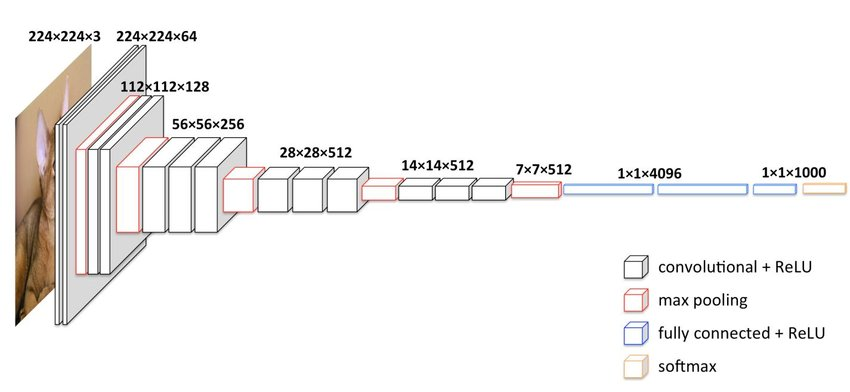

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               102600    
                                                                 
 dense_3 (Dense)             (None, 20)                4020      
                                                                 
Total params: 14,821,308
Trainable params: 106,620
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 29s 23ms/step - loss: 2.4917 - sparse_categorical_accuracy: 0.2475 - val_l

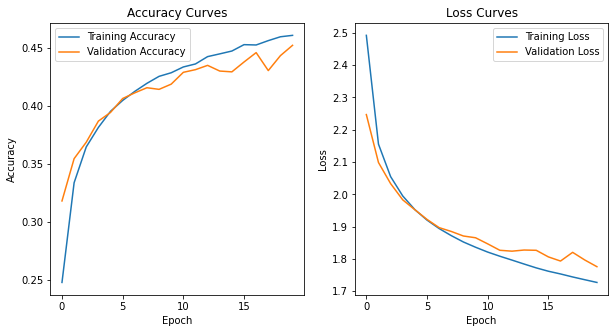

313/313 [==============================] - 6s 19ms/step - loss: 1.7776 - sparse_categorical_accuracy: 0.4435
Test set loss: 1.78, test set accuracy: 44.35%


In [ ]:
############################## Transfer Learning : Coarse Labels ######################################
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np

################### pre-process images ######################################
x_cnn_train = np.transpose(a = images, axes = (3,0,1,2))
x_cnn_test = np.transpose(a = images_test, axes = (3,0,1,2))
print(x_cnn_train.shape)
print(x_cnn_test.shape)

####################### Normalize Pixel Values ############################
max_pixel_value = np.max(x_cnn_train)
x_cnn_train_norm = x_cnn_train/max_pixel_value
x_cnn_test_norm = x_cnn_test/max_pixel_value


####################### define transfer learning base model #################
INPUT_IMAGE_SIZE = [32, 32, 3]

vgg_16 = VGG16(
    include_top = False, #### remove top(Dense) layers 
    weights = "imagenet",
    input_shape = INPUT_IMAGE_SIZE
)
vgg_16.trainable = False #### avoid retrain the feature extraction layers

########### feature extraction layers ###############
model = Sequential()
model.add(vgg_16)

########### classification layers ##################
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(20, activation='softmax'))

################### Build the model ######################
model.compile(optimizer=tf.keras.optimizers.SGD(), # Strochastic Gradient Descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy

################# Print The Summary #################
model.summary()

################# Train The Model ######################
history = model.fit(x_cnn_train_norm, y_train_coarse, epochs=20, validation_split=0.2, verbose=1)

################ Plot Accuracy And Loss Curves ################
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

################### Evaluate With Test Datatset ###########################
results = model.evaluate(x_cnn_test_norm, y_test_coarse)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               102600    
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
Total params: 14,837,388
Trainable params: 122,700
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 31s 24ms/step - loss: 4.3691 - sparse_categorical_accuracy: 0.0643 - val_l

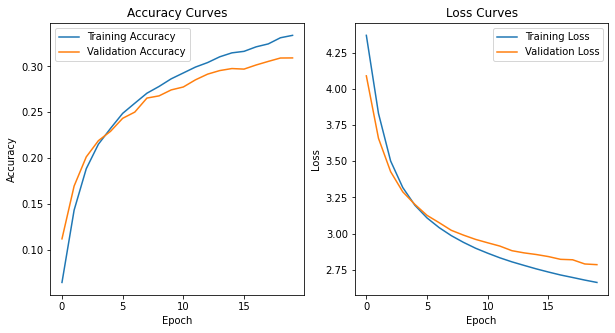

313/313 [==============================] - 6s 19ms/step - loss: 2.7517 - sparse_categorical_accuracy: 0.3152
Test set loss: 2.75, test set accuracy: 31.52%


In [ ]:
############################## Transfer Learning : Fine Labels ######################################
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np

################### pre-process images ######################################
x_cnn_train = np.transpose(a = images, axes = (3,0,1,2))
x_cnn_test = np.transpose(a = images_test, axes = (3,0,1,2))
print(x_cnn_train.shape)
print(x_cnn_test.shape)

####################### Normalize Pixel Values ############################
max_pixel_value = np.max(x_cnn_train)
x_cnn_train_norm = x_cnn_train/max_pixel_value
x_cnn_test_norm = x_cnn_test/max_pixel_value


####################### define transfer learning base model #################
INPUT_IMAGE_SIZE = [32, 32, 3]

vgg_16 = VGG16(
    include_top = False, #### remove top(Dense) layers 
    weights = "imagenet",
    input_shape = INPUT_IMAGE_SIZE
)
vgg_16.trainable = False #### avoid retrain the feature extraction layers

########### feature extraction layers ###############
model = Sequential()
model.add(vgg_16)

########### classification layers ##################
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='softmax'))

################### Build the model ######################
model.compile(optimizer=tf.keras.optimizers.SGD(), # Strochastic Gradient Descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy

################# Print The Summary #################
model.summary()

################# Train The Model ######################
history = model.fit(x_cnn_train_norm, y_train, epochs=20, validation_split=0.2, verbose=1)

################ Plot Accuracy And Loss Curves ################
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

################### Evaluate With Test Datatset ###########################
results = model.evaluate(x_cnn_test_norm, y_test)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

**References**

https://keras.io/guides/keras_tuner/getting_started/

http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/

https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

https://www.sparknotes.com/math/precalc/exponentialandlogarithmicfunctions/section2/

https://d2l.ai/chapter_convolutional-modern/vgg.html
https://machinelearningmastery.com/

**Need to study**
* Random Optimisation
* Basian Optimisation
* Gamma
* Logspace